In this cycle we:

- We'll try to recover the 135080 customers id, that was previously null (it may contain valuable info)
- 

# 1 IMPORTS

In [1]:
import re
import pandas as pd
import inflection
import seaborn as sns
import numpy as np
import umap.umap_ as umap
import sweetviz as sv

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn import cluster as c
from sklearn import metrics as m
from IPython.display import Image
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [4]:
df_raw.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  invoice_date  unit_price  customer_id         country  
0   2016-11-29        2.55      17850.0  United Kingdom  
1   2016-11-29        3.39      17850.0  United Kingdom  
2   2016-11-29        2.75      17850.0  United Kingdom  
3   2016-11-29        3.39      17850.0  United Kingdom  
4   2016-11-29        3.39      17850.0  United Kingdom

## 2.2 Data Format and Types

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2.3 NA Checking and Treatment

In [6]:
df_raw.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.3.1 Treating Missing Values

In [7]:
# adding 'No description' to missing discription
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

# deleting NAs customer_id (this removed about 25% of our database)
# df_raw.dropna(subset=['customer_id'], inplace=True)

# creating customers_id
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_not_missing = df_raw.loc[~df_raw['customer_id'].isna(), :]

df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df_raw = pd.merge( df_raw, df_backup, on='invoice_no', how='left' )

# coalesce 
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first( df_raw['customer_id_y'] )

# drop extra columns
df_raw = df_raw.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )



In [8]:
df_raw.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.4 Changing types

In [9]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [10]:
df_clean = df_raw.copy()

### 2.5.1 Numerical Attributes

Important findings:

- We found a huge negative value in quantitiy (that can be due to product return, or cancelled purchase)
- We found a zero minimum price (what is the root cause of this? promotions? coupons?)
- We found a lot of negative values in quantity

In [11]:
num_att = df_clean.select_dtypes(['int64', 'float64', 'int'])

In [12]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
ma = pd.concat([describe, skew, kurtosis], axis=0)
ma

quantity  unit_price  customer_id
count     541909.00   541909.00    541909.00
mean           9.55        4.61     16688.84
std          218.08       96.76      2911.41
min       -80995.00   -11062.06     12346.00
25%            1.00        1.25     14367.00
50%            3.00        2.08     16249.00
75%           10.00        4.13     18283.00
max        80995.00    38970.00     22709.00
skew          -0.26      186.51         0.49
kurtosis  119769.16    59005.72        -0.80

### 2.5.2 Categorical Attributes

In [13]:
cat_att = df_clean.select_dtypes(['object'])

In [14]:
cat_att.apply( lambda x: x.unique().shape[0] )

invoice_no     25900
stock_code      4070
description     4224
country           38
dtype: int64

In [15]:
df_letter_invoices = df_clean.loc[df_clean['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


# 3 DATAFRAME FILTERING

In [16]:
# =========================================================================================
# Check if its worth to treat the invoice_no and stock_code with letters in the values
# =========================================================================================

# # invoice_no
# df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
# df_letter_invoices.head()

# print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

# # stock_code
# # check stock codes only characters
# df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()


## 3.1 Line Filtering

In [17]:
# filtering zero values in unit_price (WE WILL CONSIDER THESE ITEMS AS PROMO OR ERROR)
df_clean.query('unit_price >= 0.04 ', inplace=True)

# Considering negative quantities as devolutions and positive quantities as real purchases
df_clean_returns = df_clean.query('quantity < 0')
df_clean = df_clean.query('quantity >=0')

# removing stock codes that does not represent puchases
df_clean = df_clean[~df_clean['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# removing innacurate country information 
df_clean = df_clean[~df_clean['country'].isin( ['European Community', 'Unspecified' ] ) ]

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

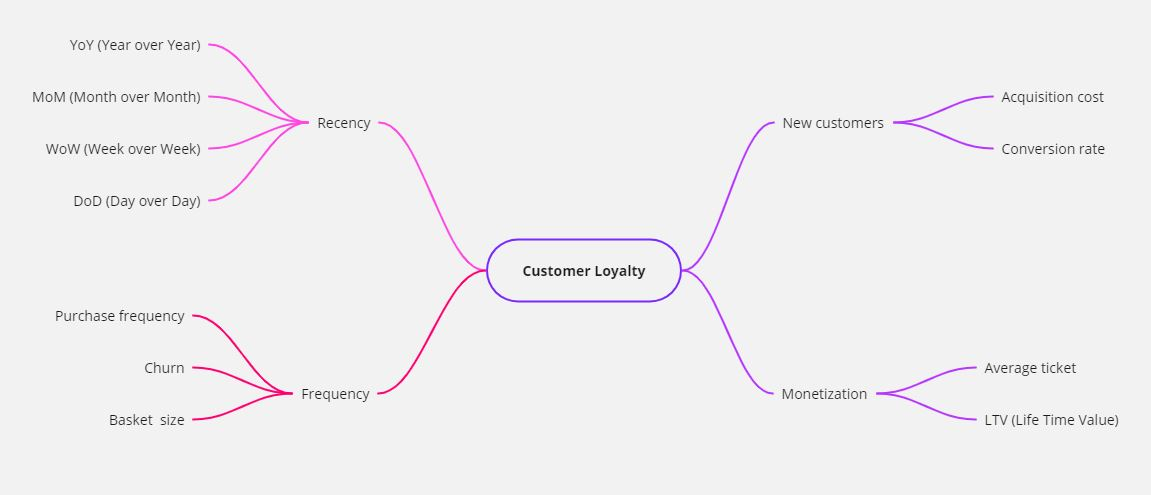

In [18]:
Image( '../images/mindmap.JPG' )

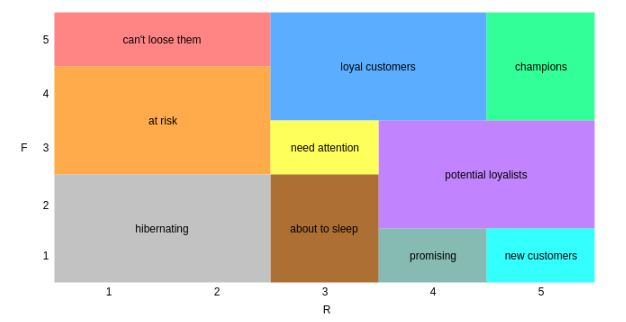

In [19]:
Image( '../images/rfm.JPG' )

Picture - https://medium.com/codex/crm-analytics-rfm-analysis-90aa2ae55fbc

# 5 FEATURE ENGINEERING

In [20]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [21]:
# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_rfm = pd.merge( df_rfm, df_monetary, on='customer_id', how='left' )


In [22]:
# recency - last purchase
df_recency = df_clean[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_clean['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge( df_rfm, df_recency, on='customer_id', how='left' )

In [23]:
# amount of purchases
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'amount_invoices'})
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )

In [24]:
# amount of purchased items
df_prod = df_clean[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'amount_items'})
df_rfm = pd.merge( df_rfm, df_prod, on='customer_id', how='left' )


In [25]:
# amount of purchased products
# Numero de produtos
df_freq = (df_clean.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'amount_products'} ) )
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )


In [26]:
# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_rfm = pd.merge( df_rfm, df_avg_ticket, on='customer_id', how='left')

In [27]:
# number of returns
df_number_returns = df_clean_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'amount_returns'})
df_number_returns['amount_returns'] = df_number_returns['amount_returns'] * -1
df_rfm = pd.merge( df_rfm, df_number_returns, on='customer_id', how='left')
df_rfm.loc[df_rfm['amount_returns'].isna(), 'amount_returns'] = 0
# df_rfm['amount_returns'].fillna(value=0, inplace=True)

In [28]:
# Average recency days
df_aux = df_clean[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date
df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )
df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

df_rfm = pd.merge( df_rfm, df_avg_recency_days, on='customer_id', how='left' )


In [29]:
# frequency purchase 
df_aux = ( df_clean[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [30]:
# basket size (Units by basket)
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )

In [31]:
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )

In [32]:
df_rfm.isna().sum()

customer_id                  0
gross_revenue                0
recency_days                 0
amount_invoices              0
amount_items                 0
amount_products              0
avg_ticket                   0
amount_returns               0
avg_recency_days          2922
frequency                    0
avg_basket_size              0
avg_unique_basket_size       0
dtype: int64

In [33]:
df_rfm.head()

customer_id  gross_revenue  recency_days  amount_invoices  amount_items  \
0        17850        5391.21           372               34          1733   
1        13047        3232.59            56                9          1390   
2        12583        6705.38             2               15          5028   
3        13748         948.25            95                5           439   
4        15100         876.00           333                3            80   

   amount_products  avg_ticket  amount_returns  avg_recency_days  frequency  \
0              297   18.152222            40.0         -1.000000  17.000000   
1              171   18.904035            36.0        -52.833333   0.028302   
2              232   28.902500            51.0        -26.500000   0.040323   
3               28   33.866071             0.0        -92.666667   0.017921   
4                3  292.000000            22.0        -20.000000   0.073171   

   avg_basket_size  avg_unique_basket_size  
0        50.970588                0.617647  
1       154.444444               11.666667  
2       335.200000                7.600000  
3        87.800000                4.800000  
4        26.666667                0.333333

# 6 EXPLORATORY DATA ANALYSIS

In [34]:
df_rfm.dropna(inplace=True)

## 6.1 Univariate Analysis

In [35]:
profile = ProfileReport( df_rfm )
profile.to_file( 'profile_report.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
report = sv.analyze(df_rfm)
report.show_html('sweetviz_report.html')

                                             |                                             | [  0%]   00:00 ->…

C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packages\sweetviz\graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
C:\Users\Rodrigo\anaconda3\envs\env_portfolio\lib\site-packag

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 6.1.1 Response Variable

### 6.1.2 Numerical Variable

### 6.1.3 Categorical Variable

## 6.2 Bivariate Analysis

## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

### 6.3.2 Categorical Attributes

# 7 DATA PREPARATION

## 7.2 Normalization

In [37]:
## Standard Scalaer
ss = pp.StandardScaler()

df_rfm['gross_revenue'] = ss.fit_transform( df_rfm[['gross_revenue']] )
df_rfm['recency_days'] = ss.fit_transform( df_rfm[['recency_days']] )
df_rfm['invoice_no'] = ss.fit_transform( df_rfm[['invoice_no']] )
df_rfm['avg_ticket'] = ss.fit_transform( df_rfm[['avg_ticket']] )
df_rfm['returns'] = ss.fit_transform( df_rfm[['returns']] )

KeyError: "None of [Index(['invoice_no'], dtype='object')] are in the [columns]"

In [ ]:
df_rfm.head()

## 7.3 Rescaling

## 7.4 Transformation

### 7.4.1 Encoding

# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and validation dataset

## 8.3 Selected Features

# 9 MACHINE LEARNING MODELLING

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]
X = df_rfm.drop( columns=['customer_id'] )

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show()

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

In [ ]:
fig, ax = plt.subplots( 3, 2, figsize=(28, 20) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## KMEANS 3 Clusters

In [ ]:
kmeans = c.KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=42) 
kmeans.fit(X)
labels = kmeans.labels_

In [ ]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

In [ ]:
df_rfm['cluster'] = labels
df_rfm.head()

### 9.1.1 Silhouette Visualization

In [ ]:
df_viz = df_rfm.drop(columns='customer_id')

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.1.1 Pairplot Visualization

In [ ]:
sns.pairplot(df_viz, hue='cluster')

### 9.1.1 UMAP 

In [ ]:
reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

### 9.1.2 Clusters Info

In [ ]:
# Number of customer
df_cluster = df_rfm[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df_rfm[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# # Avg Ticket
# df_ticket = df_rfm[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
# df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster' )

df_cluster

# 10 CROSS-VALIDATION

# 11 HYPERPARAMETER FINE TUNNING

## 11.1 Random Search

## 11.2 Final Model

# 12 BUSINESS PERFORMANCE

Cluster 01: 
- Number of customers: 6 (0.14% of customers )
- Average Recency: 7 days
- Average invoice_no: 89 
- Average Gross Revenue: U\$182,182.00

Cluster 02:
- Number of customers: 28 (0.64% of customers )
- Average Recency: 6 days
- Average invoice_no: 58 
- Average Gross Revenue: U\$42,614.38 

Cluster 03:
- NNumber of customers: 4.071 (93% of customers )
- Average Recency: 97 days
- Average invoice_no: 3.6 
- Average Gross Revenue: U\$946.69 

Cluster 04:
- NNumber of customers: 267 (6.1% of customers )
- Average Recency: 20.3 days
- Average invoice_no: 19.5 
- Average Gross Revenue: U\$8,092.02 

## 12.1 Scenario: Cost to Reach 87% of Interested Customers

## 12.2 Scenario: Making only 20,000 calls

# 13 NEXT STEPS